<a href="https://colab.research.google.com/github/amazzoli/RL_introduction/blob/main/notebooks/Gridworld_with_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gridworld

*Andrea Mazzolini*, andrea.mazzolini.90@gmail.com.


Here we want to find the optimal strategy of a 2d grid-world problem using a model-free reinforcement-learning algorithm: **Q-learning**.

## Gridworld as a Markov Decision Process

### States
The state space is the physical cartesian space of the gridworld, identified by the two coordinates.
Assuming that it is a square of side $d$, the whole state space is composed of $d^2$ states:

$$
\mathcal{S} = \{ 0, 1, \ldots, d-1 \} \times \{ 0, 1, \ldots, d-1 \}
$$

### Actions
The actions of the agent are five: they can move to nearest neighbors or stay in the cell without moving, which can be expressed also as translation vectors.

$$
\mathcal{A} = \{ \text{up}, \text{left}, \text{down}, \text{right}, \text{stay} \} = \{ (0,1), (-1,0), (0,-1), (1,0), (0,0)\}
$$

Actually, these actions are not always possible in each state: the agent cannot cross boundaries or possible internal obstacles.
This makes actions state dependent, for example if the agent is located on the left boundary they cannot go left, $\mathcal{A}(0,y) = \{ \text{up}, \text{down}, \text{right}, \text{stay} \}$, or in a corner: $\mathcal{A}(d-1,d-1) = \{ \text{left}, \text{down}, \text{stay} \}$.

### Transition probabilities

The transition probabilities between states are deterministic: the next state is just the old state plus the translation action chosen by the agent:

$$
p(s_{t+1} | a_t, s_t) = \delta (s_{t+1} - (a_t + s_t))
$$

### Rewards

The rewards depend only on the arrival states, $r(s_{t+1})$, and are zero for all the states with the exception of some special cells that contain a treasure.
Here we decide to not delete the treasure after the agent arrives on the cell, in a way that if they decide to stay they can collect the reward also at the future steps.

### Aim of the game

The agent has to learn to get the treasure by following the fastest path from a given initial cell.
In formula, we want to maximize the return

$$
G_\pi = \sum_{t=0}^\infty \gamma^t\, R_{t,\pi} ,
$$

where $\gamma$, the time horizon, introduces the time scale within which we want to acquire the treasure and $R$ is the stochastic variable corresponding to the reward acquired at time $t$ following the policy $\pi$.
The policy $\pi(a | s)$ is our strategy that gives the probability of choosing $a \in \mathcal{A}(s)$ (the direction of the next step) from state $s$ (the coordinate in which we are), therefore is telling us how to navigate the map.

## Q-learning

Q-learning is a reinforcement learning algorithm for any finite Markov Decision Processes (state and action space must be discrete and finite), which can converge to an optimal policy for maximizing an exponentially discounted return.
It does not require a model (hence the connotation "model-free") of the environment and it just tries and learns from experience.
For a "model" we mean the knowledge of the transition probabilities and reward function of the MDP. Differently, Value Iteration relies on this information.

### Table for the state-action qualities

The general idea is to build a table of estimates of "goodness" of each state and action pairs.
This goodness of state $s$ and action $a$ is called quality function $Q^*(s,a)$, and it is the best possible return the agent can get from $s$ choosing $a$.

$$
Q^*(s,a) = \max_{\pi} \; \mathbb{E}_\pi\left[ G_\pi \; \Big| \; s_0 = s, \; a_0 = a \right]
$$

We then call ${Q}(s, a)$ (without star) quality table or quality matrix, our estimate for that function.
It can be proven that, when the algorithm converges: $ Q(s,a) \rightarrow Q^*(s,a)$.

By assuming that $Q$ is a good estimate of $Q^*$, the best policy is deterministic and consists in choosing the action that leads to the best possible return:

$$
\pi^*(a | s) = \delta (a - \text{argmax}_{b \in \mathcal{A}} Q(s,b))
$$

### Finding the quality matrix

The core of the algorithm is a simple online quality update that in the long run will make our quality table converge to the best quality function.

At time $t$ the learning agent is in the state $s_t$ and takes the action $a_t$ (later we specify how to choose the action). As a consequence it moves to a new state $S_{t+1}$ taking the reward $R_t$. Note that $S_{t+1}$ and $R_t$ are stochastic outcomes of the MDP (this is why they are written in capital letters), depending on the transition probabilities and the policy.
The Q-learning update rule for the Quality is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(R_t + \gamma \max_{b \in \mathcal{A}} Q(S_{t+1}, b) - Q(s_t, a_t)\right)
$$

where $\gamma$ is the discount factor and $\alpha$ is a learning rate.

Note that there is a reason for the update rule above to work.
It is leading to a stable fixed point that is given by setting to zero the quantity in the parenthesis, which corresponds to

$$
Q(s_t, a_t) = R_t + \gamma \max_{b \in \mathcal{A}} Q(S_{t+1}, b) .
$$

This equation, that the update rule wants to satisfy, is a close relative of  the Bellman equation, $Q(s_t, a_t)^* = \mathbb{E} \left[ r_t + \gamma \max_b Q^*(s_{t+1}, b) \right] $, which is satisfied for the optimal policy.
There is however a small difference between the two: the Bellman equation has an average value over all the possible trajectories of our process, which can lead to different rewards and new states.
The update rule considers only the single sample that we are seeing at that instance of the process.
However, one can imagine that if we pass several times from the same state and action, in the limit of small learning rate, the update rule will average over all of them.
In other words, the update rule for Q-learning implements the Bellman equation that will lead to the right quality function.


### Pseudocode for Q-learning

The algorithm consists in starting from an initial configuration for the quality table (e.g. all the entries for $s$ and $a$ have the same value), and then "play the game":
$$
s_0, a_0 \rightarrow r_0, s_1, a_1 \rightarrow r_1, s_2, a_2 \rightarrow \ldots
$$
The quality table will be updated at every step with the rule above.

We still have to specify how to choose actions. Here we consider a simple and widely used protocol called *epsilon-greedy*. Let us define two way of choosing the action:
- **Exploration** move, where the action is chosen uniformly at random among the possible actions from the state in which the agent is.
- **Exploitation** move, where the action is taken as the one that maximizes my current qualities, which is the best action that I can take according to my estimates of the returns, $a_t = \text{argmax}_b Q(s_t, b)$.

An epsilon-greedy strategy says that the exploration move is chosen with probability $\epsilon$, and the exploitation move with $1 - ϵ$.

Putting everything together, the core series of instructions for an epsilon-greedy Q-learning algorithm is the following:

 - Initialize the Q-matrix and choose the algorithm parameters $\gamma$, $\alpha$, $\epsilon$.
 - Set the agent in the starting state $s_0$.
 - For $t = 1, \ldots$ until convergence:
> - With probability $\epsilon$ choose $a_t$ at random from the possible actions, otherwise choose the action that maximizes the qualities $a_t = \text{argmax}_b Q(s_t, b)$.
> - Play a step in the game and get the new state and the reward $s_t, a_t \rightarrow S_{t+1}, R_t$
> - Update the quality matrix
> $$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(R_t + \gamma \max_b Q(S_{t+1}, b) - Q(s_t, a_t)\right)
$$

### Episodic game and exploration scheduling

Actually one usually introduces two tricks to speed up the covergence of the quality table.

The first is to restart the game after a given number of steps (the state is forced to be $s_0$ again). Each of these runs is called episode. This is natural if there are terminal states and, at some point, the game finishes, but this is not our case. For us, this comes in handy bacause we can imagine that we are interested in a particular initial condition (the initial cell in which we put our agent). In this way, I force the algorithm to explore more around there and have better estimates of the quality.

A second trick is to schedule the exporation parameter $\epsilon$. Usually, I want the exploration to be large at the beginning, to have an approximate idea of all the possible qualities. Later, when I'm more confident about their values I want instead to focus on the best moves to have more fine-tuned estimates of them, forgetting about the bad actions.
This transition from explortation to exploitation is typical of reinforcement learning. Quantitative and precise prescriptions on how to do it in practice typically are available only for extremely simple problems, and choosing the right protocol in general is more of an art than a science.

Rewriting the pseudocode above we have:

 - Initialize the Q-matrix and choose the algorithm parameters $\gamma$, $\alpha$, $T_{episode}$ and how to schedule the exploration probability $ϵ_e$ ($e$ is the episode index).
> For episodes $e = 1, \ldots$ until convergence:
> - Set the agent in the starting state $s_0$.
> - For steps in the episode $t = 1, \ldots, T_{episode}$:
>> - With probability $\epsilon_e$ choose $a_t$ at random from the possible actions, otherwise choose the action that maximizes the Qualities $a_t = \text{argmax}_b Q(s_t, b)$.
>> - Play a step in the game and get the new state and the reward $s_t, a_t \rightarrow S_{t+1}, R_t$
>> - Update the quality matrix
>> $$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(R_t + \gamma \max_b Q(S_{t+1}, b) - Q(s_t, a_t)\right)
$$
> - Decrease the exploration rate $\epsilon_e$.

## Implementation

### Environment class: the gridworld

The Gridworld class contains all the information about the environment:
- The info about the state space, the current state of the game and the initial state.
- The set of possible actions.
- The reward table: which reward the agent take in each cell (0 if none).

The methods are:
- `reset()`: the game is initialized at the beginning of a episode. Here the only initialization is to put the agent in the starting cell.
- `step(action)`: update the agent state according to the `action` passed and compute reward. Returns the state after the transition (the movement) and the reward.


In [ ]:
import numpy as np
from copy import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm


class Gridworld:

  def __init__(self, grid_size, init_cell, rewards, obstacles=[]):
    """
    Training environment for reinforcement learning: gridworld.
    Args:
    - grid_size, (int, int): defining the size of the 2d lattice
    - init_cell, (int, int): coordinates from 0 to size-1 from which the agent starts to play
    - rewards, list((int, int), float): list of the coordinates and values of the rewards
    - obstacles, lits((int, int)): list of the coordinates of the obstacles
    """

    # Define state space
    self.state = None  # current state of the game
    self.state_dim = grid_size
    self.init_state = init_cell
    self.obstacles = obstacles
    # Cells that are not obstacles
    self.states = [(i,j) for i in range(self.state_dim[0]) for j in range(self.state_dim[1]) if (i,j) not in self.obstacles]

    # Define action space
    self.action_dim = (5,)  # up, right, down, left, stay
    self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3, "stay": 4}
    self.action_coords = [(0, 1), (1, 0), (0, -1), (-1, 0), (0, 0)]  # translations
    self.actions_allowed = self._build_allowed_actions(obstacles)

    # Define rewards table
    self.R = self._build_rewards(rewards)


  def reset(self):
    """Reset agent state to its initial cell"""
    self.state = self.init_state
    return self.state


  def step(self, action):
    """Update agent state"""
    state_next = (self.state[0] + self.action_coords[action][0],
                  self.state[1] + self.action_coords[action][1])
    # Collect reward
    reward = self.R[self.state]
    # Update state
    self.state = state_next
    return state_next, reward


  def _build_allowed_actions(self, obstacles):
    actions_allowed = dict()
    Nx, Ny = self.state_dim
    for x in range(Nx):
      for y in range(Ny):
        # Actions not allowed at the boundaries
        actions_allowed[(x,y)] = [self.action_dict["stay"]] # The stay action is always allowed
        if (y > 0):
          actions_allowed[(x,y)].append(self.action_dict["down"])
        if (y < Ny - 1):
          actions_allowed[(x,y)].append(self.action_dict["up"])
        if (x > 0):
          actions_allowed[(x,y)].append(self.action_dict["left"])
        if (x < Nx - 1):
          actions_allowed[(x,y)].append(self.action_dict["right"])
        actions_allowed[(x,y)] = np.array(actions_allowed[(x,y)], dtype=int)
        # Actions not allowed because of obstacles
        for o in obstacles:
          if (x+1,y) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["right"]]
          if (x-1,y) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["left"]]
          if (x,y+1) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["up"]]
          if (x,y-1) == o:
            actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["down"]]
    return actions_allowed


  def _build_rewards(self, rewards):
      R = np.zeros(self.state_dim, dtype=float)
      for rew in rewards:
        R[rew[0]] = rew[1]
      return R

  def display(self, ax, values=np.array([]), cmap=cm["Reds"]):
    """
    Plot the map on the axis object ax. It's possible to add a color to each cell, e.g. its value,
    by passing a properly sized vectors of values
    """

    cmap.set_bad("black")
    obstacle_mask = np.zeros(self.state_dim, dtype=bool)
    for obs in obstacles:
      obstacle_mask[obs[0], obs[1]] = True

    if len(values)==0:
      ax = sns.heatmap(obstacle_mask.T, cmap=cm["Greys"], cbar=False,
                       linewidths=0.1, linecolor='#222222')
    else:
      ax = sns.heatmap(values.T, mask=obstacle_mask.T, cmap=cmap,
                       linewidths=0.1, linecolor='#222222', vmin=np.min(values[values != 0]))
      ax.collections[0].colorbar.set_label("Value", fontsize=14)

    ax.invert_yaxis()
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.scatter([start_cell[0]+0.5],[start_cell[1]+0.5], s=100, c='grey', label='Start')
    for rew in rewards:
      ax.scatter([rew[0][0]+0.5],[rew[0][1]+0.5], s=200*rew[1], c='#ffcc00', label='Reward:{}'.format(rew[1]), marker='*')

    return ax


  def display_best_path(self, ax, Q, start_coord, lcolor='black', values=np.array([]), cmap=cm["Reds"]):
    """
    Plot the map and display the best path on the axis object ax.
    """

    ax = self.display(ax, values, cmap)

    s, count, best_action = start_coord, 0, 0
    while best_action != 4 or count < self.state_dim[0]*self.state_dim[1]:
      count += 1
      best_action = np.argmax(Q[s[0], s[1], :])
      new_s = s[0] + self.action_coords[best_action][0], s[1] + self.action_coords[best_action][1]
      ax.plot([s[0]+0.5, new_s[0]+0.5], [s[1]+0.5, new_s[1]+0.5], c='black', lw=3)
      s = new_s

    return ax

### Building the gridworld

As stated before, we build a griword with two rewards: one large and far away from the starting state, one smaller and closer.

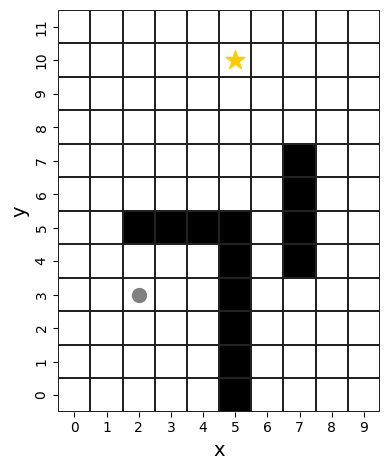

In [ ]:
world_size = (10,12) # dimension of the gridworld

start_cell = (2,3)
obstacles = [(2,5), (3,5), (4,5), (5,5), (5,4), (5,3), (5,2), (5,1), (5,0),
             (7,4), (7,5), (7,6), (7,7)]
#rewards = [((8,6), 2), ((5, 10), 1)]
rewards = [((5, 10), 1)]

gridworld = Gridworld(world_size, start_cell, rewards, obstacles) # Building the world

fig, ax = plt.subplots(figsize=(world_size[0]/2.5, world_size[1]/2.5))
ax = gridworld.display(ax) # And showing it

plt.tight_layout()
#plt.savefig('Gridwrold.png', dpi=200)

## Agent class: the Q-learning algorithm


This class defines how the agent chooses the action from each state and how to improve its strategy while playing.
It employs a Q-learning algorithm with an epsilon-greedy policy.
In particular:
- `get_action()` returns an action using the epsilon greedy rule.
- `train()` performs one step of the Q-learning update.

In [ ]:
import operator

class QL_agent:

  def __init__(self, env, gamma, learning_rate=0.1, eps_decay=0.995, init_Q=0):

    # Store the environment
    self.env = env

    # Agent learning parameters
    self.epsilon = 1.0  # initial exploration probability
    self.epsilon_decay = eps_decay  # epsilon decay after each episode
    self.alpha = learning_rate
    self.gamma = gamma  # reward discount factor

    # Initialize Quality matrix
    self.Q = np.ones(env.state_dim + env.action_dim, dtype=float)*init_Q


  def get_action(self):
    """
    Choose an action using an epsilon greedy policy: random with probability
    epsilon, greedy otherwise.
    """
    state = self.env.state
    actions_allowed = self.env.actions_allowed[state]
    if np.random.rand() < self.epsilon:  # explore
      return np.random.choice(actions_allowed)
    else:  # exploit
      Q_s = self.Q[state[0], state[1], actions_allowed]
      actions_greedy = actions_allowed[np.flatnonzero(Q_s == np.max(Q_s))]
      return np.random.choice(actions_greedy)


  def train(self, transition):
    """
    Q-learning update
    """
    (state, action, state_next, reward) = transition
    sa = state + (action,)
    td_error = reward + gamma * np.max(self.Q[state_next]) - self.Q[sa]
    self.Q[sa] += self.alpha * td_error

  @property
  def values(self):
    vals = np.zeros(self.env.state_dim)
    for i in range(len(self.Q)):
      for j in range(len(self.Q[0])):
        vals[i,j] = np.max(self.Q[i,j])
    return vals

  def display_greedy_policy(self):
    greedy_policy = np.zeros((self.env.state_dim[0], self.env.state_dim[1]), dtype=str)
    for x in range(self.env.state_dim[0]):
        for y in range(self.env.state_dim[1]):
            greedy_policy[x, y] = str(np.argmax(self.Q[x, y, :]))
    for o in obstacles:
      greedy_policy[o[0],o[1]] = 'x'
    print("\nGreedy policy for gamma={}:".format(self.gamma))
    print(greedy_policy.T[::-1])
    for (key, val) in sorted(self.env.action_dict.items(), key=operator.itemgetter(1)):
      print(" action['{}'] = {}".format(key, val))
    print("x: obstacle")

### Main learning cycle

It follows the pseudocode written before.

In [ ]:
n_episodes = 1000
n_steps_in_episode = 100
eps_decay = 0.999 # Multiplicative decay factor for the exploration rate
gamma = 0.9
learning_rate=0.1

agent = QL_agent(gridworld, gamma, learning_rate, eps_decay)

# Iteration over all the episodes
for episode in range(n_episodes):

  state = gridworld.reset() # Setting the agent in the initial cell

  for _ in range(n_steps_in_episode):
    action = agent.get_action()  # get action
    state_next, reward = gridworld.step(action)  # evolve state by action
    agent.train((state, action, state_next, reward)) # train agent
    state = state_next  # transition to next state

  agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.02) # Decrease the exploration
  # Show training info
  sys.stdout.write("\rEpisode: " + str(episode+1) + "/" + str(n_episodes) + " epsilon: " + str(agent.epsilon))
  sys.stdout.flush()

Episode: 1000/1000 epsilon: 0.3676954247709635

<Axes: xlabel='x', ylabel='y'>

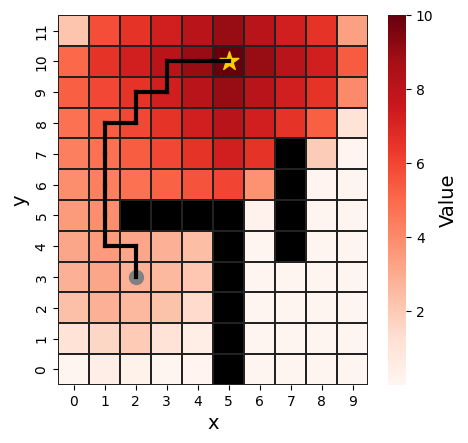

In [ ]:
fig, ax = plt.subplots(figsize=(world_size[0]/2.5 + 1, world_size[1]/2.5))
gridworld.display_best_path(ax, agent.Q, start_cell, values=agent.values)

### Tasks

- Try to change the exploration decay rate and see how a more "exploitative" algorithm does. What do you notice? How can this be risky?

- Can you build a new map with one close small reward and one far away and large? Can you find two gammas such that for one value the agent prefers the small and for the other the large reward?
Be careful of the learning parameters, if you complexify the system, you will probably need more episodes or explore more...